In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- DATA INSPECTION FOR CLASSIFICATION DATASETS ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Load your classification dataset (Adult Income)
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv('adult.data', header=None, names=column_names, na_values=' ?')


# --- General Dataset Overview ---

print("=== Dataset Info ===")
print(df.info())

print("\n=== Dataset Shape ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")


#  --- Missing Value Analysis (includes '?', blanks) ---
# Detect NaN
missing_counts = df.isna().sum()

# Detect other missing markers
missing_question = (df.astype(str).apply(lambda x: x.str.strip()) == "?").sum()
missing_empty = (df.astype(str).apply(lambda x: x.str.strip()) == "").sum()

# Combine total missing counts
total_missing = missing_counts + missing_question + missing_empty

print("\n=== Missing Values per Column (Including '?', blanks) ===")
print(total_missing[total_missing > 0].sort_values(ascending=False))


print("\n=== Categorical Summary (unique values per column) ===")
print(df.select_dtypes(include='object').nunique())




=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
None

=== Dataset Shape ===
Rows: 32561, Columns: 15

=== Missing Values


=== Statistical Summary (Numeric Columns) ===
                  count           mean            std      min       25%  \
age             32561.0      38.581647      13.640433     17.0      28.0   
fnlwgt          32561.0  189778.366512  105549.977697  12285.0  117827.0   
education-num   32561.0      10.080679       2.572720      1.0       9.0   
capital-gain    32561.0    1077.648844    7385.292085      0.0       0.0   
capital-loss    32561.0      87.303830     402.960219      0.0       0.0   
hours-per-week  32561.0      40.437456      12.347429      1.0      40.0   

                     50%       75%        max  missing_values  unique_values  \
age                 37.0      48.0       90.0               0             73   
fnlwgt          178356.0  237051.0  1484705.0               0          21648   
education-num       10.0      12.0       16.0               0             16   
capital-gain         0.0       0.0    99999.0               0            119   
capital-loss        

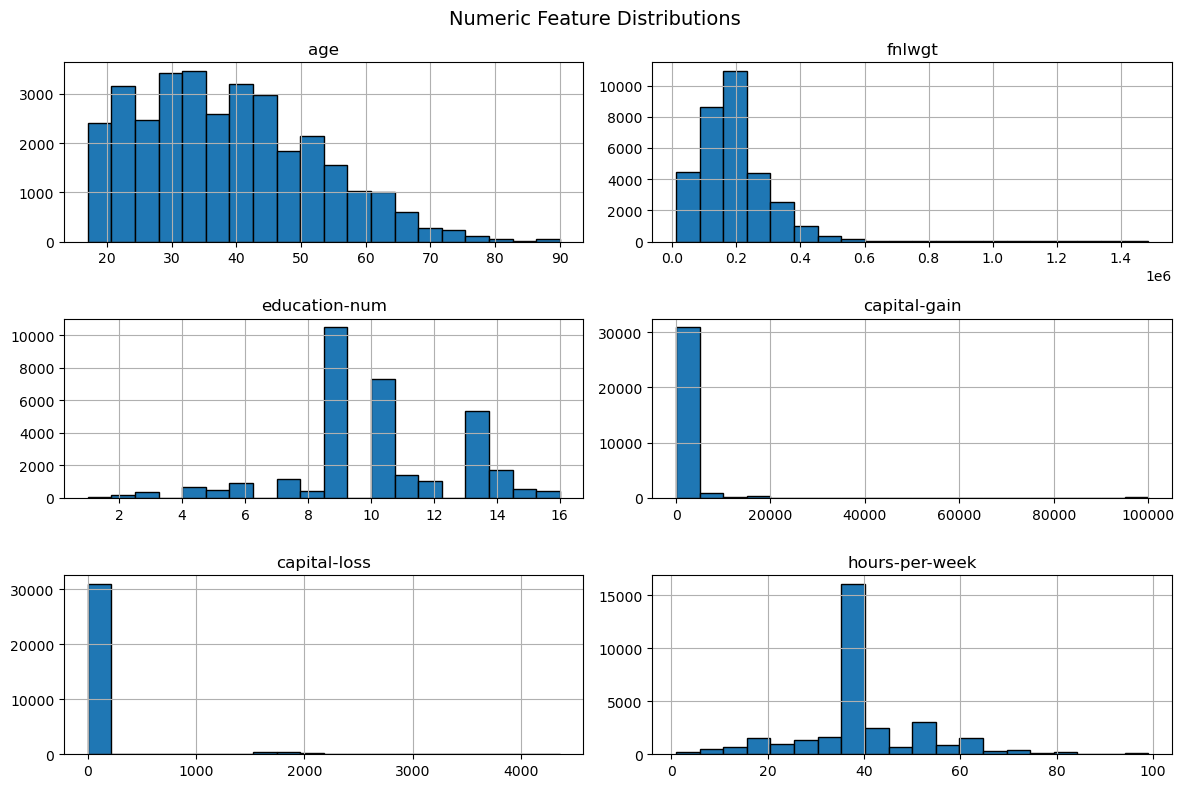

In [3]:
# --- NUMERIC FEATURE SUMMARY (for Classification) ---

print("\n=== Statistical Summary (Numeric Columns) ===")

# Select numeric columns only
numeric_df = df.select_dtypes(include=[np.number])

# Summary statistics
summary = numeric_df.describe().T

# Add extra info for better insight
summary["missing_values"] = numeric_df.isna().sum()
summary["unique_values"] = numeric_df.nunique()
summary["skewness"] = numeric_df.skew()

# Display neatly
print(summary)

# Optional: visualize distributions
numeric_df.hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Numeric Feature Distributions", fontsize=14)
plt.tight_layout()
plt.show()


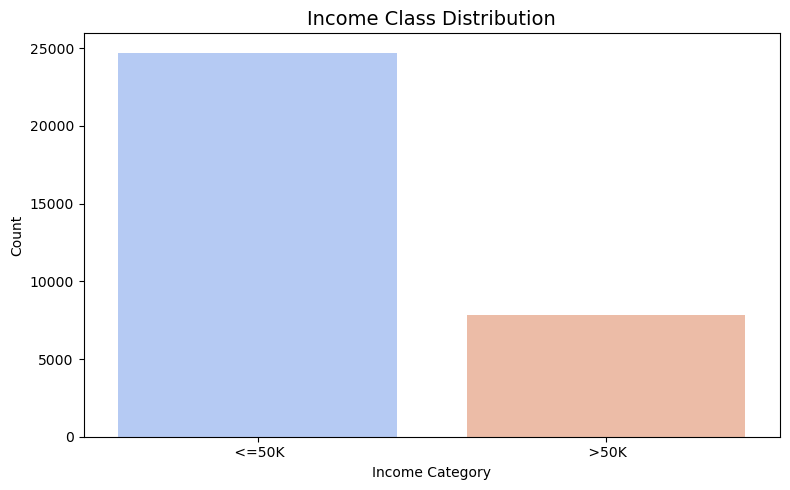


=== Target Class Balance ===
income
<=50K    24720
>50K      7841
Name: count, dtype: int64

=== Class Proportions (%) ===
income
<=50K    75.92
>50K     24.08
Name: proportion, dtype: float64


In [4]:
# --- Target Variable Distribution (Adult Dataset) ---

plt.figure(figsize=(8, 5))
sns.countplot(x='income', hue='income', data=df, palette='coolwarm', legend=False)

plt.title('Income Class Distribution', fontsize=14)
plt.xlabel('Income Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Optional: Print class balance summary
print("\n=== Target Class Balance ===")
print(df['income'].value_counts())

print("\n=== Class Proportions (%) ===")
print((df['income'].value_counts(normalize=True) * 100).round(2))


In [5]:
# --- Handle Missing Data (for Classification) ---

# Replace '?' and empty strings with NaN to standardize missing values
df = df.replace(['?', ''], np.nan)

# Check missing counts again after standardization
print("\n=== Missing Values per Column (after standardization) ===")
print(df.isna().sum()[df.isna().sum() > 0].sort_values(ascending=False))

# Separate columns by type
categorical_cols = df.select_dtypes(include=['object']).columns


# --- Handle Missing Values — Categorical Columns ---
for col in categorical_cols:
    missing = df[col].isna().sum()
    if missing > 0:
        # Replace missing categories with a new label 'Unknown'
        df[col] = df[col].fillna('Unknown')
        print(f"Filled {missing} missing values in '{col}' with 'Unknown'")



=== Missing Values per Column (after standardization) ===
occupation        1843
workclass         1836
native-country     583
dtype: int64
Filled 1836 missing values in 'workclass' with 'Unknown'
Filled 1843 missing values in 'occupation' with 'Unknown'
Filled 583 missing values in 'native-country' with 'Unknown'


In [6]:
#  --- Handle Duplicate Records ---

# Count duplicates before removal
duplicates_before = df.duplicated().sum()
print(f"Number of duplicate rows before removal: {duplicates_before}")


# Drop duplicate rows (keep first occurrence)
df = df.drop_duplicates(keep='first')

# Count duplicates after removal
duplicates_after = df.duplicated().sum()
print(f"\n Number of duplicate rows after removal: {duplicates_after}")

# Final shape check
print(f"\nDataset shape after duplicate removal: {df.shape}")


Number of duplicate rows before removal: 24

 Number of duplicate rows after removal: 0

Dataset shape after duplicate removal: (32537, 15)


In [7]:
# Identify numeric columns (exclude target 'income')
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Handle missing or placeholder values (e.g., '?')
df = df.replace(' ?', np.nan)
df = df.dropna()

# Detect and cap outliers for each numeric column
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)]
    print(f"{col}: {len(outliers)} outliers detected")

    # Cap the outliers (instead of removing)
    df[col] = np.where(df[col] > upper_limit, upper_limit,
                np.where(df[col] < lower_limit, lower_limit, df[col]))

print(" Outlier capping done for all numeric features.")

age: 142 outliers detected
fnlwgt: 993 outliers detected
education-num: 1193 outliers detected
capital-gain: 2712 outliers detected
capital-loss: 1519 outliers detected
hours-per-week: 9002 outliers detected
 Outlier capping done for all numeric features.


In [8]:
# --- FEATURE ENGINEERING FOR ADULT DATASET ---
import pandas as pd
import numpy as np

# --- Load dataset ---
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]


# --- Clean column names (ensure underscores) ---
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_')

# --- Feature Engineering ---

# Age group bins
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 45, 65, 100],
                         labels=['young', 'adult', 'mid-age', 'senior'])

# Simplify workclass
df['workclass_simplified'] = df['workclass'].replace({
    'Never-worked': 'Other',
    'Without-pay': 'Other',
    'Federal-gov': 'Gov',
    'State-gov': 'Gov',
    'Local-gov': 'Gov',
    '?': 'Other'
})

# Marital status simplified
df['marital_status_type'] = df['marital_status'].apply(
    lambda x: 'Married' if 'Married' in x else 'Single'
)

# Net capital gain/loss
df['capital_diff'] = df['capital_gain'] - df['capital_loss']

# Work hours grouped
df['hours_per_week_group'] = pd.cut(df['hours_per_week'],
                                    bins=[0, 25, 40, 60, 100],
                                    labels=['part-time', 'full-time', 'overtime', 'heavy'])

# Simplify native country (top 5 kept, rest as 'Other')
top_countries = df['native_country'].value_counts().nlargest(5).index
df['native_country_grouped'] = df['native_country'].apply(
    lambda x: x if x in top_countries else 'Other'
)

# Log transform education_num
df['education_num_log'] = np.log(df['education_num'] + 1)

# Drop redundant columns
df = df.drop(['fnlwgt', 'native_country'], axis=1)

# --- Identify categorical and numerical columns ---
categorical_cols = [
    'workclass', 'education', 'marital_status', 'occupation',
    'relationship', 'race', 'sex',
    'age_group', 'workclass_simplified', 'marital_status_type',
    'hours_per_week_group', 'native_country_grouped'
]

numerical_cols = [
    'age', 'education_num', 'education_num_log',
    'capital_gain', 'capital_loss', 'capital_diff', 'hours_per_week'
]

target = 'income'

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)
print("Target:", target)

print("\nFeature Engineering Completed! Preview:")
display(df.head())


Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'age_group', 'workclass_simplified', 'marital_status_type', 'hours_per_week_group', 'native_country_grouped']
Numerical columns: ['age', 'education_num', 'education_num_log', 'capital_gain', 'capital_loss', 'capital_diff', 'hours_per_week']
Target: income

Feature Engineering Completed! Preview:


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income,age_group,workclass_simplified,marital_status_type,capital_diff,hours_per_week_group,native_country_grouped,education_num_log
0,39.0,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,0.0,0.0,40.0,<=50K,adult,State-gov,Single,0.0,full-time,United-States,2.639057
1,50.0,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,32.5,<=50K,mid-age,Self-emp-not-inc,Married,0.0,full-time,United-States,2.639057
2,38.0,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,<=50K,adult,Private,Single,0.0,full-time,United-States,2.302585
3,53.0,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,<=50K,mid-age,Private,Married,0.0,full-time,United-States,2.079442
4,28.0,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,<=50K,adult,Private,Married,0.0,full-time,Other,2.639057


In [9]:
#  --- ENCODING & NORMALIZATION FOR ADULT DATASET ---
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# --- Label Encoding for Random Forest (df_rf) ---

df_rf = df.copy()
label_encoders = {}

# Encode each categorical column with LabelEncoder
for col in categorical_cols:
    le = LabelEncoder()
    df_rf[col] = le.fit_transform(df_rf[col].astype(str))
    label_encoders[col] = le  # store encoder (for inverse transform if needed)

# Encode target column ('income')
target_encoder = LabelEncoder()
df_rf[target] = target_encoder.fit_transform(df_rf[target])

print(" Random Forest Encoding Completed!")
display(df_rf.head())

# ---  One-Hot Encoding + Normalization for Deep Learning (df_dl) ---

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# Apply One-Hot Encoding for categorical columns
column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ],
    remainder='passthrough'  # keep numerical columns
)

X_encoded = column_transformer.fit_transform(X)

# Get feature names after encoding
encoded_feature_names = list(column_transformer.get_feature_names_out())

# Create DataFrame after encoding
df_dl = pd.DataFrame(X_encoded, columns=encoded_feature_names)

# Apply MinMaxScaler to normalize all features between 0–1
scaler = MinMaxScaler()
df_dl_scaled = pd.DataFrame(scaler.fit_transform(df_dl), columns=df_dl.columns)

# Encode target (for deep learning output)
y_encoded = target_encoder.fit_transform(y)

print("\n Deep Learning Encoding & Normalization Completed!")
print(f"Feature count after One-Hot Encoding: {df_dl_scaled.shape[1]}")
print("Target classes:", list(target_encoder.classes_))

# ---  Final Outputs ---

# df_rf  → Random Forest-ready (Label Encoded)
# df_dl_scaled → Deep Learning-ready (One-Hot + Scaled)
# y_encoded → Target vector for both models

# Optional preview
print("\n Random Forest dataset shape:", df_rf.shape)
print(" Deep Learning dataset shape:", df_dl_scaled.shape)

display(df_rf.head())
display(df_dl_scaled.head())


 Random Forest Encoding Completed!


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income,age_group,workclass_simplified,marital_status_type,capital_diff,hours_per_week_group,native_country_grouped,education_num_log
0,39.0,6,9,13.0,4,0,1,4,1,0.0,0.0,40.0,0,0,6,1,0.0,0,3,2.639057
1,50.0,5,9,13.0,2,3,0,4,1,0.0,0.0,32.5,0,1,5,0,0.0,0,3,2.639057
2,38.0,3,11,9.0,0,5,1,4,1,0.0,0.0,40.0,0,0,3,1,0.0,0,3,2.302585
3,53.0,3,1,7.0,2,5,0,2,1,0.0,0.0,40.0,0,1,3,0,0.0,0,3,2.079442
4,28.0,3,9,13.0,2,9,5,2,0,0.0,0.0,40.0,0,0,3,0,0.0,0,4,2.639057



 Deep Learning Encoding & Normalization Completed!
Feature count after One-Hot Encoding: 90
Target classes: [' <=50K', ' >50K']

 Random Forest dataset shape: (32537, 20)
 Deep Learning dataset shape: (32537, 90)


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,income,age_group,workclass_simplified,marital_status_type,capital_diff,hours_per_week_group,native_country_grouped,education_num_log
0,39.0,6,9,13.0,4,0,1,4,1,0.0,0.0,40.0,0,0,6,1,0.0,0,3,2.639057
1,50.0,5,9,13.0,2,3,0,4,1,0.0,0.0,32.5,0,1,5,0,0.0,0,3,2.639057
2,38.0,3,11,9.0,0,5,1,4,1,0.0,0.0,40.0,0,0,3,1,0.0,0,3,2.302585
3,53.0,3,1,7.0,2,5,0,2,1,0.0,0.0,40.0,0,1,3,0,0.0,0,3,2.079442
4,28.0,3,9,13.0,2,9,5,2,0,0.0,0.0,40.0,0,0,3,0,0.0,0,4,2.639057


,onehot__workclass_ Federal-gov,onehot__workclass_ Local-gov,onehot__workclass_ Never-worked,onehot__workclass_ Private,onehot__workclass_ Self-emp-inc,onehot__workclass_ Self-emp-not-inc,onehot__workclass_ State-gov,onehot__workclass_ Without-pay,onehot__workclass_Unknown,onehot__education_ 10th,...,onehot__native_country_grouped_ United-States,onehot__native_country_grouped_Other,onehot__native_country_grouped_Unknown,remainder__age,remainder__education_num,remainder__capital_gain,remainder__capital_loss,remainder__hours_per_week,remainder__capital_diff,remainder__education_num_log
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.360656,0.739130,0.0,0.0,0.375,0.0,0.827947
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.540984,0.739130,0.0,0.0,0.000,0.0,0.827947
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.344262,0.391304,0.0,0.0,0.375,0.0,0.529779
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.590164,0.217391,0.0,0.0,0.375,0.0,0.332038
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.180328,0.739130,0.0,0.0,0.375,0.0,0.827947


In [10]:
# --- SAVE PROCESSED DATASETS TO CSV FILES ---
# Save Random Forest version
rf_path = "adult_done_randomforest.csv"
df_rf.to_csv(rf_path, index=False)
print(f" Random Forest dataset saved as: {rf_path}")

# Save Deep Learning version
dl_path = "adult_done_deeplearning.csv"
df_dl_scaled[target] = y_encoded  # add target back
df_dl_scaled.to_csv(dl_path, index=False)
print(f" Deep Learning dataset saved as: {dl_path}")


 Random Forest dataset saved as: adult_done_randomforest.csv
 Deep Learning dataset saved as: adult_done_deeplearning.csv


In [11]:
# --- TRAIN–TEST SPLIT ---

from sklearn.model_selection import train_test_split

# ---  Random Forest version ---

# Separate features and target
X_rf = df_rf.drop(columns=[target])
y_rf = df_rf[target]

# Split 80% train / 20% test
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=42, stratify=y_rf
)

print(" Random Forest split complete!")
print("Training shape:", X_train_rf.shape)
print("Testing shape:", X_test_rf.shape)


# ---  Deep Learning version ---
# Separate features and target
X_dl = df_dl_scaled.drop(columns=[target])
y_dl = df_dl_scaled[target]

# Split 80% train / 20% test
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl
)

print("\n Deep Learning split complete!")
print("Training shape:", X_train_dl.shape)
print("Testing shape:", X_test_dl.shape)



 Random Forest split complete!
Training shape: (26029, 19)
Testing shape: (6508, 19)

 Deep Learning split complete!
Training shape: (26029, 90)
Testing shape: (6508, 90)


 Training Random Forest model...

 MODEL PERFORMANCE SUMMARY
Accuracy : 0.8207
F1 Score : 0.6714
ROC-AUC  : 0.8886

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      4940
           1       0.60      0.76      0.67      1568

    accuracy                           0.82      6508
   macro avg       0.76      0.80      0.77      6508
weighted avg       0.84      0.82      0.83      6508



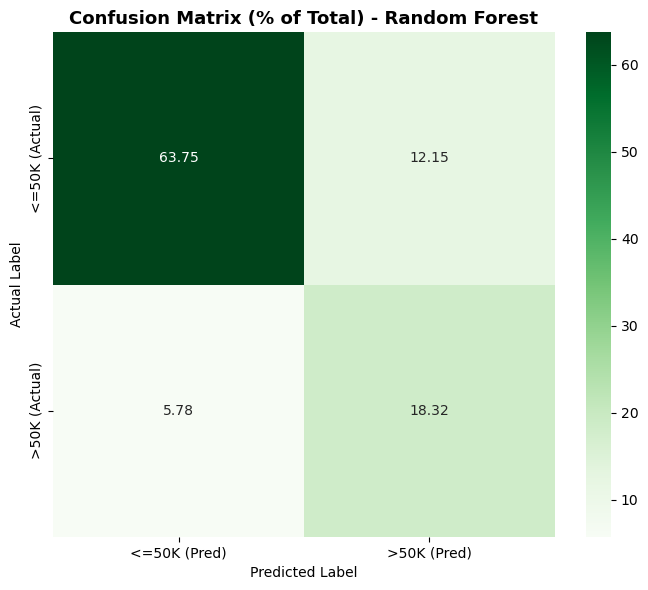

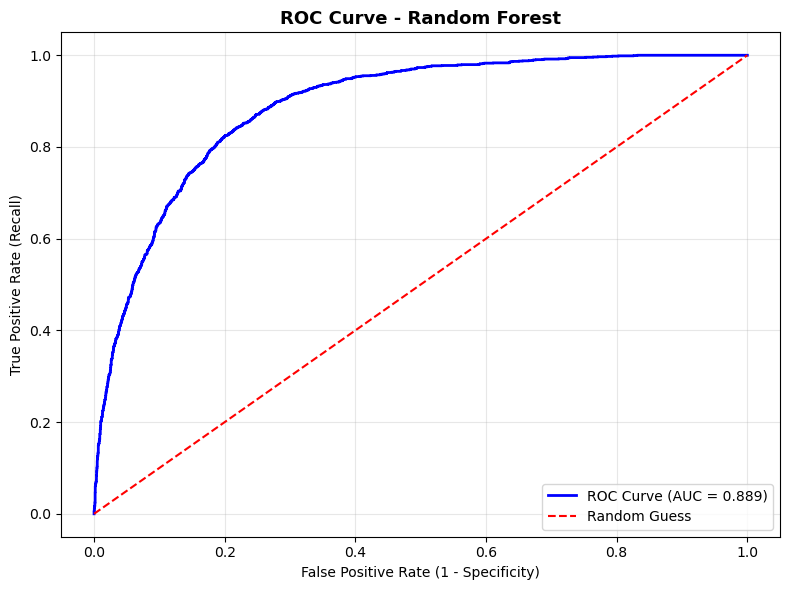

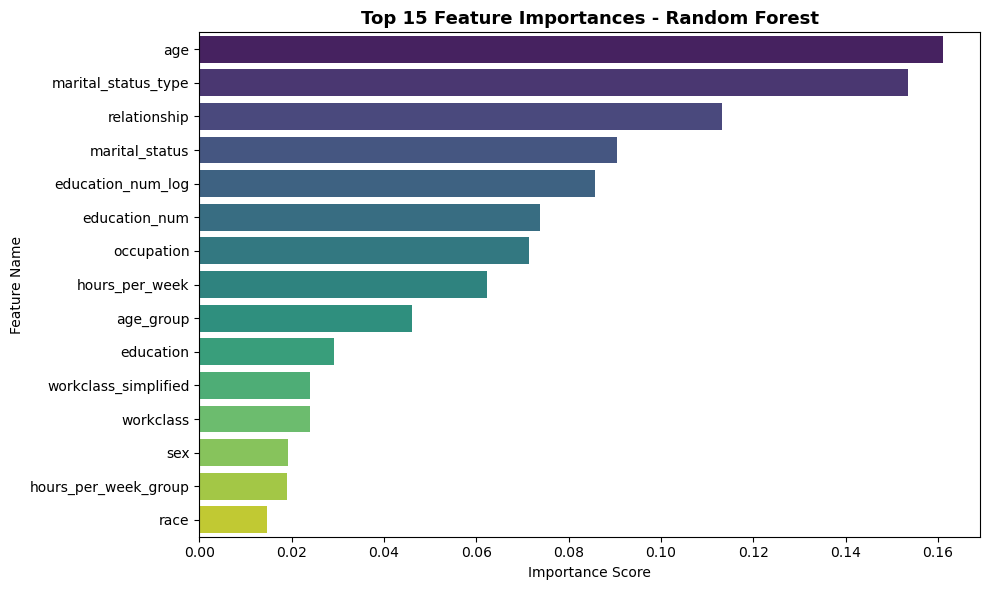

In [12]:
#  --- RANDOM FOREST  ---
# Trains, evaluates, and visualizes a Random Forest Classifier
# on the Adult Income dataset with F1-score, accuracy, and clear visuals.
# Handles imbalanced datasets well
# Random Forest gives a strong, explainable baseline

#  --- Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

#  --- Load and Prepare Data ---
df = pd.read_csv("adult_done_randomforest.csv")
X = df.drop("income", axis=1)
y = df["income"]

# Encode target if necessary
if y.dtype == 'object':
    y = y.map({'>50K': 1, '<=50K': 0})

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


#  --- Build and Train Random Forest ---
rf_model = RandomForestClassifier(
    n_estimators=400,              # Number of trees in the forest
    max_depth=None,                # Fully grown trees
    min_samples_split=5,           # Split condition
    min_samples_leaf=2,            # Minimum leaf size
    random_state=42,               # Reproducibility
    n_jobs=-1,                     # All CPU cores
    class_weight='balanced_subsample'  # Handle imbalance
)

print(" Training Random Forest model...")
rf_model.fit(X_train, y_train)


# --- Evaluate Model ---
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # probability of class 1


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display metrics in a clean summary box
print("\n MODEL PERFORMANCE SUMMARY")
print("=" * 40)
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")
print("=" * 40)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


#  --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100  # Convert to percentages

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_percent, annot=True, fmt=".2f", cmap="Greens",
    xticklabels=["<=50K (Pred)", ">50K (Pred)"],
    yticklabels=["<=50K (Actual)", ">50K (Actual)"]
)
plt.title("Confusion Matrix (% of Total) - Random Forest", fontsize=13, weight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


#  --- ROC Curve Analysis ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'r--', label="Random Guess", linewidth=1.5)
plt.title("ROC Curve - Random Forest", fontsize=13, weight="bold")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Recall)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


#  --- Feature Importance Visualization ---
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(15), y=importances.head(15).index, palette='viridis')
plt.title("Top 15 Feature Importances - Random Forest", fontsize=13, weight="bold")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()



=== Cross-Validation Results (Random Forest) ===
Fold Accuracies: [0.81684081 0.8165335  0.81281697 0.81681266 0.81327801]
Mean Accuracy   : 0.8153
Std Deviation   : 0.0018


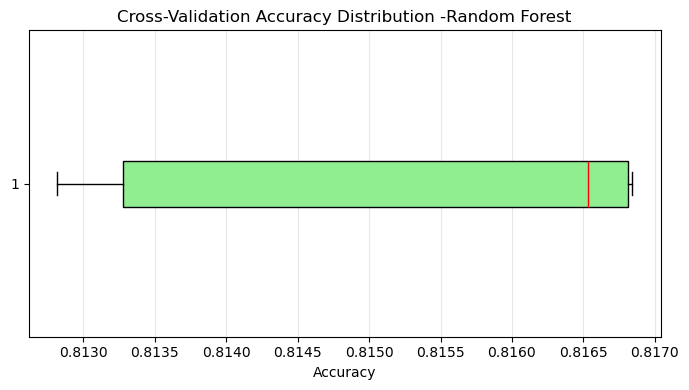

In [13]:
# ======================================================
# 🔁 Step: Cross-Validation for Random Forest Classifier
# ======================================================

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initialize model
rf_cv_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced_subsample'
)

# Define Stratified K-Fold (preserves class distribution)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation (using accuracy as metric)
cv_scores = cross_val_score(rf_cv_model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("=== Cross-Validation Results (Random Forest) ===")
print(f"Fold Accuracies: {cv_scores}")
print(f"Mean Accuracy   : {cv_scores.mean():.4f}")
print(f"Std Deviation   : {cv_scores.std():.4f}")


plt.figure(figsize=(7,4))
plt.boxplot(cv_scores, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'))
plt.title("Cross-Validation Accuracy Distribution -Random Forest")
plt.xlabel("Accuracy")
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

Epoch 1/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8156 - loss: 0.3834 - val_accuracy: 0.8357 - val_loss: 0.3522
Epoch 2/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8289 - loss: 0.3611 - val_accuracy: 0.8391 - val_loss: 0.3454
Epoch 3/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8295 - loss: 0.3576 - val_accuracy: 0.8367 - val_loss: 0.3464
Epoch 4/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8332 - loss: 0.3549 - val_accuracy: 0.8394 - val_loss: 0.3438
Epoch 5/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8340 - loss: 0.3533 - val_accuracy: 0.8382 - val_loss: 0.3444
Epoch 6/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8350 - loss: 0.3521 - val_accuracy: 0.8436 - val_loss: 0.3394
Epoch 7/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8333 - loss: 0.3513 - val_accuracy: 0.8425 - val_loss: 0.3415
Epoch 8/30
407/407 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8356 - loss: 0.3513 - val_accuracy: 0.

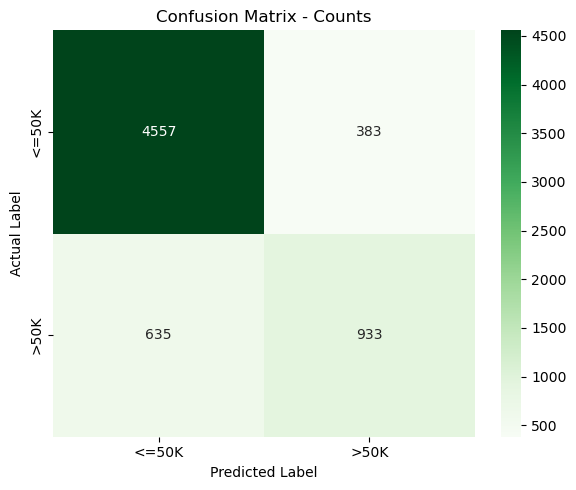

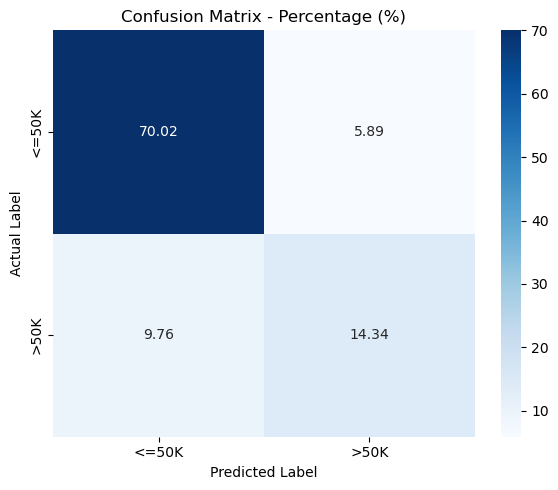

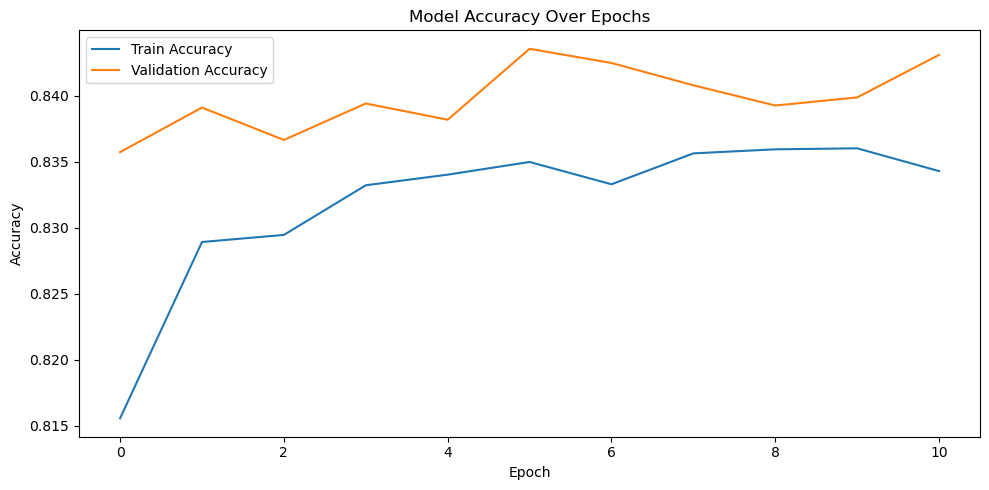

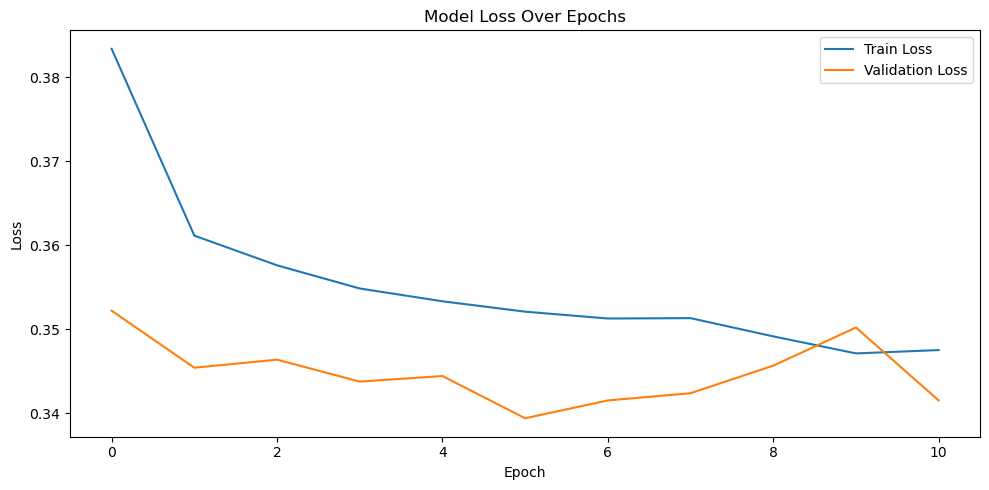

In [14]:
# --- NEURAL NETWORK CLASSIFIER (ADAM OPTIMIZER) ---
# Neural Network models complex feature interactions.


#  --- Import required libraries ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#  --- Load the dataset ---

df = pd.read_csv("adult_done_deeplearning.csv")

# --- Split into features (X) and target (y) ---

X = df.drop("income", axis=1)
y = df["income"]

# If the target is text, convert it to numeric (binary)
if y.dtype == 'object':
    y = y.map({'>50K': 1, '<=50K': 0})


#   ---Train/Test Split ---

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  ---Feature Scaling ---

# Neural networks perform better when inputs are standardized (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#  ---Build the Neural Network Architecture ---

# - Input layer: size matches number of features
# - Hidden layers: progressively smaller layers to compress information
# - Activation: ReLU (Rectified Linear Unit)
#     → Allows model to learn non-linear patterns efficiently
# - Output layer: 1 neuron with sigmoid activation
#     → Converts output into probability (0 to 1) for binary classification

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),    # Input layer — matches number of features
    layers.Dropout(0.3),  # Drop 30% of neurons randomly
    layers.Dense(128, activation='relu'),       # Hidden layer 1: learns complex feature interactions 
    layers.Dense(64, activation='relu'),        # Hidden layer 2: refines representations
    layers.Dense(32, activation='relu'),        # Hidden layer 3: captures finer patterns
    layers.Dense(1, activation='sigmoid')       # Output layer: sigmoid gives probability (0–1)
])

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', # Tells the model which metric to watch during training to decide when to stop or save the best version.
    patience=5,           # stop if val_loss doesn’t improve for 5 epochs
    restore_best_weights=True
)

#  --- Compile the Model ---

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy', # Measures how well the predicted probabilities match the true labels (0 or 1).
    metrics=['accuracy']
)

#  ---Train the Model ---
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=30, 
    batch_size=64,
    callbacks = [early_stop],
    verbose=1
)


#   ---Evaluate the Model ---

# Convert probabilities to binary classes using threshold = 0.5
y_pred_prob = model.predict(X_test_scaled).flatten()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Compute metrics
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("\n Neural Network Performance Summary:")
print(f"Accuracy : {accuracy:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# ---  Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
cm_labels = ['<=50K', '>50K']

# Normalize to percentages
cm_percent = cm / np.sum(cm) * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix - Counts")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.title("Confusion Matrix - Percentage (%)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()


#--- Training Curves ---

# Visualize how accuracy and loss evolved over epochs
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()




 Fold 1
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
 Fold 1 Accuracy: 0.8357

 Fold 2
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
 Fold 2 Accuracy: 0.8390

 Fold 3
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
 Fold 3 Accuracy: 0.8334

 Fold 4
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 Fold 4 Accuracy: 0.8408

 Fold 5
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
 Fold 5 Accuracy: 0.8316

=== Cross-Validation Results ===
Fold Accuracies: [0.83574063 0.83896742 0.83341017 0.84078684 0.83156601]
Mean Accuracy : 0.8361
Std Deviation : 0.0034


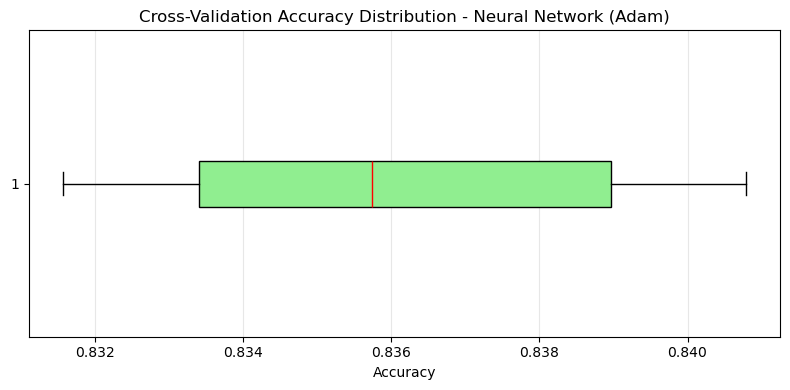

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# --- Encode target ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Clean data ---
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# --- Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Define model creation function ---
def create_nn_model(input_dim):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- Manual Cross-Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

fold = 1
for train_idx, test_idx in kf.split(X_scaled, y_encoded):
    print(f"\n Fold {fold}")
    X_train_fold, X_test_fold = X_scaled[train_idx], X_scaled[test_idx]
    y_train_fold, y_test_fold = y_encoded[train_idx], y_encoded[test_idx]

    model = create_nn_model(X.shape[1])
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_test_fold, y_test_fold),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    # Evaluate on test fold
    y_pred_prob = model.predict(X_test_fold)
    y_pred = (y_pred_prob > 0.5).astype(int)
    acc = accuracy_score(y_test_fold, y_pred)
    cv_scores.append(acc)
    print(f" Fold {fold} Accuracy: {acc:.4f}")

    fold += 1

# --- Results summary ---
cv_scores = np.array(cv_scores)
print("\n=== Cross-Validation Results ===")
print(f"Fold Accuracies: {cv_scores}")
print(f"Mean Accuracy : {cv_scores.mean():.4f}")
print(f"Std Deviation : {cv_scores.std():.4f}")

# --- Visualization ---
plt.figure(figsize=(8,4))
plt.boxplot(cv_scores, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'))
plt.title("Cross-Validation Accuracy Distribution - Neural Network (Adam)")
plt.xlabel("Accuracy")
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


In [16]:
# --- DROP-COLUMN FEATURE IMPORTANCE FOR MLP CLASSIFIER ---

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

def drop_column_importance(model, X_scaled, y, feature_names, metric=accuracy_score):
    """
    Computes feature importance for a Keras neural network classifier
    using the drop-column method.
    
    Args:
        model: trained Keras model
        X_scaled: scaled features (numpy array)
        y: target labels (array-like)
        feature_names: list of feature names (same order as X_scaled)
        metric: scoring function (default accuracy_score)
    
    Returns:
        pd.DataFrame: feature importance (sorted by drop in accuracy)
    """
    baseline_pred = (model.predict(X_scaled).flatten() >= 0.5).astype(int)
    baseline_score = metric(y, baseline_pred)
    importances = []

    for i, col in enumerate(feature_names):
        X_temp = X_scaled.copy()
        X_temp[:, i] = 0  # zero-out one feature at a time
        y_pred_temp = (model.predict(X_temp).flatten() >= 0.5).astype(int)
        score = metric(y, y_pred_temp)
        importance = baseline_score - score
        importances.append(importance)
        print(f"Feature: {col}, Drop in Accuracy: {importance:.6f}")

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)

    return importance_df


# --- APPLY TO YOUR DATA ---

# Use column names from the original dataframe
feature_names = X_train.columns.tolist()

# Compute feature importance
importance_df = drop_column_importance(model, X_test_scaled, y_test.values, feature_names)

print("\nTop 10 Features by Drop in Accuracy:")
print(importance_df.head(10))


204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Federal-gov, Drop in Accuracy: 0.000307
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Local-gov, Drop in Accuracy: 0.001229
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Never-worked, Drop in Accuracy: 0.000000
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Private, Drop in Accuracy: 0.000154
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Self-emp-inc, Drop in Accuracy: -0.001076
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Self-emp-not-inc, Drop in Accuracy: 0.001076
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ State-gov, Drop in Accuracy: 0.000768
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_ Without-pay, Drop in Accuracy: 0.000154
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature: onehot__workclass_Unknown, 